In [0]:
# 1. Завантаження даних

delta_input_path = "/Volumes/workspace/default/olist_delta_2"
olist_df = spark.read.format("delta").load(delta_input_path)

print("Rows:", olist_df.count())
display(olist_df.limit(5))


Rows: 97762


order_id customer_id numeric_scaled order_status_ohe customer_id_ohe purchase_year purchase_month purchase_day purchase_weekday delivery_time_days_calc orders_per_customer avg_delivery_days ccbabeb0b02433bd0fcbac46e70339f2 c77ee2d8ba1614a4d489a44166894938 {"type":"1","size":null,"indices":null,"values":["0.9212620248057964","-1.2435964538639488","0.4027424113392373","-1.011294959616418","-1.1594387074188466","0.6083045965080545"]} {"type":"0","size":"7","indices":["0"],"values":["1.0"]} {"type":"0","size":"97761","indices":["76451"],"values":["1.0"]} 2018 2 19 2 18 1 18.0 c6bf92017bd40729c135b58b643f64c2 3d3c463710ea6e8dd9a63c1110eeb06b {"type":"1","size":null,"indices":null,"values":["0.9212620248057964","0.6042294965367236","-0.8689660624435991","0.04437592842202428","0.5394262246592859","-0.6544254259646151"]} {"type":"0","size":"7","indices":["0"],"values":["1.0"]} {"type":"0","size":"97761","indices":["23416"],"values":["1.0"]} 2018 8 8 4 7 1 7.0 ab87dc5a5f1856a10640d5f42e4c2fd9 538a4d02876412846b966a3c057395e5 {"type":"1","size":null,"indices":null,"values":["0.9212620248057964","-0.011712486930167146","-1.3314055074555395","-1.011294959616418","-0.09764812487001377","-0.6544254259646151"]} {"type":"0","size":"7","indices":["0"],"values":["1.0"]} {"type":"0","size":"97761","indices":["31836"],"values":["1.0"]} 2018 6 4 2 7 1 7.0 06ff862a85c2402aa52dc9edf150bf30 0a978c825ff7d013133ddc7f77566172 {"type":"1","size":null,"indices":null,"values":["-1.058306255931486","1.5281424717370597","1.6744508851220739","0.5722113724412454","1.6720028460447074","1.7562409805741177"]} {"type":"0","size":"7","indices":["0"],"values":["1.0"]} {"type":"0","size":"97761","indices":["4026"],"values":["1.0"]} 2017 11 30 5 28 1 28.0 f23155f5fa9b826631c5b8e038b38393 21a99191298d34fb6dd0b088e821591c {"type":"1","size":null,"indices":null,"values":["-1.058306255931486","0.912200488270169","0.5183522725922225","0.04437592842202428","0.964142457678819","-0.08045723393158347"]} {"type":"0","size":"7","indices":["0"],"values":["1.0"]} {"type":"0","size":"97761","indices":["12892"],"values":["1.0"]} 2017 9 20 4 12 1 12.0

In [0]:
# 2. Вибір числових ознак

from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

def vector_to_list_safe(v):
    if v is None:
        return None
    try:
        return [float(x) for x in v.toArray()]
    except Exception:
        return None

vector_to_list_udf = udf(vector_to_list_safe, ArrayType(DoubleType()))

if "numeric_scaled" in olist_df.columns:
    olist_df = olist_df.withColumn("numeric_array", vector_to_list_udf(col("numeric_scaled")))
    num_features = 6
    numeric_cols = [f"num_{i+1}" for i in range(num_features)]
    for i, cname in enumerate(numeric_cols):
        olist_df = olist_df.withColumn(cname, col("numeric_array")[i])
else:
    numeric_cols = [c for c, t in olist_df.dtypes if t in ("double", "float", "int", "bigint")][:30]

print("Numeric cols:", numeric_cols[:30])


Numeric cols: ['num_1', 'num_2', 'num_3', 'num_4', 'num_5', 'num_6']


In [0]:
import pandas as pd

# Беремо підвибірку ~10% для кореляції, щоб не грузити пам'ять
sample_pd = olist_df.select(numeric_cols).sample(False, 0.1, seed=42).toPandas()
corr = sample_pd.corr()
display(corr)

# Знайдемо сильно корельовані пари |r| > 0.8
thr = 0.8
high_corr = [
    (c1, c2, corr.loc[c1, c2])
    for i, c1 in enumerate(corr.columns)
    for j, c2 in enumerate(corr.columns)
    if j > i and abs(corr.loc[c1, c2]) > thr
]
print("High correlations:", high_corr)

# ВІДБІР ОЗНАК: видаляємо другу ознаку з пари (фільтраційний метод 1 — correlation)
for c1, c2, r in high_corr:
    print(f"Drop {c2} because of high correlation with {c1} (r={r:.2f})")
    if c2 in olist_df.columns:
        olist_df = olist_df.drop(c2)
    if c2 in numeric_cols:
        numeric_cols.remove(c2)

print("Numeric cols after correlation-based selection:", len(numeric_cols))


num_1 num_2 num_3 num_4 num_5 num_6 1.0 -0.5499781362723396 -0.05973636055689195 -0.0020035101136712825 -0.5496847047727881 -0.08147090697284082 -0.5499781362723396 1.0 0.007812721477814831 0.00874317314345328 0.9959212269234262 -0.05537543975529558 -0.05973636055689195 0.007812721477814831 1.0 -0.0183018221691048 0.09547601195074905 -0.007732617058506801 -0.0020035101136712825 0.00874317314345328 -0.0183018221691048 1.0 0.001230991308279901 0.06025506141647674 -0.5496847047727881 0.9959212269234262 0.09547601195074905 0.001230991308279901 1.0 -0.05613904424386956 -0.08147090697284082 -0.05537543975529558 -0.007732617058506801 0.06025506141647674 -0.05613904424386956 1.0

High correlations: [('num_2', 'num_5', np.float64(0.9959212269234262))]
Drop num_5 because of high correlation with num_2 (r=1.00)
Numeric cols after correlation-based selection: 5


In [0]:
# 4. Інженерія нових ознак (мінімум 5)

from pyspark.sql.functions import when, lit, mean as _mean
import pyspark.sql.functions as F

# 1) Ознаки, пов’язані з часом доставки
if "delivery_time_days_calc" in olist_df.columns:
    avg_delivery = olist_df.select(_mean(col("delivery_time_days_calc"))).first()[0] or 0.0
    olist_df = olist_df.withColumn(
        "delivery_diff_avg",
        col("delivery_time_days_calc") - lit(avg_delivery)
    )
    olist_df = olist_df.withColumn(
        "fast_delivery",
        when(col("delivery_time_days_calc") < 3, 1).otherwise(0)
    )
else:
    olist_df = olist_df.withColumn("delivery_diff_avg", lit(0.0)) \
                       .withColumn("fast_delivery", lit(0))

# 2) Квадрат першої числової ознаки
olist_df = olist_df.withColumn("num_1_sq", (col("num_1") ** 2).cast("double"))

# 3) Взаємодія між двома фічами
olist_df = olist_df.withColumn(
    "num2_num3_interaction",
    (col("num_2") * col("num_3")).cast("double")
)

# 4) Середнє двох перших числових ознак
olist_df = olist_df.withColumn(
    "num_mean_12",
    ((col("num_1") + col("num_2")) / 2).cast("double")
)

# 5) Логарифм від num_1 (робимо log1p(abs(x)))
olist_df = olist_df.withColumn(
    "log_num_1",
    F.log1p(F.abs(col("num_1")))
)

# Додаємо нові фічі до списку числових
for f in ["delivery_diff_avg", "fast_delivery",
          "num_1_sq", "num2_num3_interaction",
          "num_mean_12", "log_num_1"]:
    if f in olist_df.columns and f not in numeric_cols:
        numeric_cols.append(f)

print("Нові ознаки додано. Всього числових:", len(numeric_cols))


Нові ознаки додано. Всього числових: 11


In [0]:
# 5. Масштабування + Відбір ознак (Метод 2 — Variance Threshold)

import pyspark.sql.functions as F

# Обчислюємо дисперсію для кожної фічі
var_row = olist_df.select([F.variance(col(c)).alias(c) for c in numeric_cols]).collect()[0].asDict()
var_items = [(c, float(var_row.get(c) or 0.0)) for c in numeric_cols]

# Фільтраційний метод 2: відбір за порогом дисперсії
variance_threshold = 0.01
selected_by_variance = [c for c, v in var_items if v > variance_threshold]

print("Ознаки, відібрані за порогом дисперсії (> 0.01):")
print(selected_by_variance)

# Для масштабування фічs з найвищою дисперсією
var_items_sorted = sorted(var_items, key=lambda x: x[1], reverse=True)
topk = [c for c, _ in var_items_sorted[:50]]

# mean і std тільки для top-k
stats = olist_df.select(
    *[F.mean(col(c)).alias(f"{c}_mean") for c in topk],
    *[F.stddev(col(c)).alias(f"{c}_std") for c in topk]
).collect()[0].asDict()

# Масштабування (z-score)
for c in topk:
    mean_val = stats.get(f"{c}_mean") or 0.0
    std_val = stats.get(f"{c}_std") or 1.0
    if std_val == 0:
        std_val = 1.0
    olist_df = olist_df.withColumn(f"{c}_scaled", (col(c) - mean_val) / std_val)

scaled_cols = [f"{c}_scaled" for c in topk]

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=scaled_cols,
    outputCol="numeric_scaled_features",
    handleInvalid="skip"
)
olist_df = assembler.transform(olist_df)

print(f"Масштабування виконано для {len(scaled_cols)} фіч.")
display(olist_df.select("numeric_scaled_features").limit(3))


Ознаки, відібрані за порогом дисперсії (> 0.01):
['num_1', 'num_2', 'num_3', 'num_4', 'num_6', 'delivery_diff_avg', 'fast_delivery', 'num_1_sq', 'num2_num3_interaction', 'num_mean_12']
Масштабування виконано для 11 фіч.


numeric_scaled_features {"type":"1","size":null,"indices":null,"values":["0.6083045965080447","-0.5032931879602934","0.9212620248020866","0.40274241133922173","0.6083045965080376","-1.243596453863929","-1.011294959616422","-0.312027440136112","-0.34091763055130425","-0.18912337395155587","-0.6443211270827166"]} {"type":"1","size":null,"indices":null,"values":["-0.6544254259646274","-0.5273482659803431","0.9212620248020866","-0.8689660624436027","-0.6544254259646213","0.6042294965367451","0.044375928422025014","-0.312027440136112","1.6134390496064985","-0.18912337395155587","-0.6443211270827166"]} {"type":"1","size":null,"indices":null,"values":["-0.6544254259646274","0.009932238217282584","0.9212620248020866","-1.3314055074555389","-0.6544254259646213","-0.011712486930146272","-1.011294959616422","-0.312027440136112","0.961986822887231","-0.18912337395155587","-0.6443211270827166"]}

In [0]:

import numpy as np
from sklearn.decomposition import PCA

# вибірка для аналізу
pca_sample_pd = olist_df.select(scaled_cols).sample(False, 0.02, seed=42).toPandas()

pca_input_cols = scaled_cols[:20]
X_pca = pca_sample_pd[pca_input_cols].values

pca = PCA(n_components=3, random_state=42)
X_pca_trans = pca.fit_transform(X_pca)

print("PCA (sklearn) виконано успішно.")
print("Пояснена дисперсія по компонентах:", pca.explained_variance_ratio_)
print("Сумарна пояснена дисперсія:", pca.explained_variance_ratio_.sum())

# Feature selection через PCA loadings
loadings = np.abs(pca.components_).sum(axis=0)  # сумарний внесок кожної фічі
pca_feature_importance = sorted(
    zip(pca_input_cols, loadings),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("Топ-10 найважливіших ознак за PCA loadings:")
for name, score in pca_feature_importance:
    print(f"{name}: {score:.6f}")

pca_sample_pd[["pca_1", "pca_2", "pca_3"]] = X_pca_trans
display(pca_sample_pd[["pca_1", "pca_2", "pca_3"]].head())


PCA (sklearn) виконано успішно.
Пояснена дисперсія по компонентах: [0.25156897 0.19131699 0.12772191]
Сумарна пояснена дисперсія: 0.570607871604934
Топ-10 найважливіших ознак за PCA loadings:
num_2_scaled: 1.191935
num_mean_12_scaled: 1.115430
delivery_diff_avg_scaled: 0.952025
num_6_scaled: 0.952025
log_num_1_scaled: 0.767266
num_1_scaled: 0.675324
num_1_sq_scaled: 0.654638
fast_delivery_scaled: 0.648134
num_4_scaled: 0.198259
num2_num3_interaction_scaled: 0.168672


pca_1 pca_2 pca_3 -0.9431883064227805 1.4259010427256413 -1.3219001566736879 -1.0303605692458513 1.3555940670761863 -0.6698057405774079 -0.43569828628836027 3.1761047441418624 0.4943922274590018 -1.4020617353864528 -0.006141170506979175 -0.7964983986625989 1.0986145871581274 -1.174066992608282 0.7902131634818923

In [0]:
%pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 MB 174.5 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# 7. Додаткове зменшення розмірності: UMAP 

import umap

umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_pca)

print("UMAP виконано успішно. Розмірність:", X_umap.shape)

pca_sample_pd["umap_1"] = X_umap[:, 0]
pca_sample_pd["umap_2"] = X_umap[:, 1]

display(pca_sample_pd[["umap_1", "umap_2"]].head())



/databricks/python_shell/lib/dbruntime/autoreload/discoverability/autoreload_discoverability_hook.py:72: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  return orig_warn(*args, **kwargs)


UMAP виконано успішно. Розмірність: (2023, 2)


umap_1 umap_2 15.015424 3.7537704 14.61682 -0.58972335 13.687005 0.6432853 18.306997 3.6776564 1.6095401 3.373978

Візуалізація UMAP...


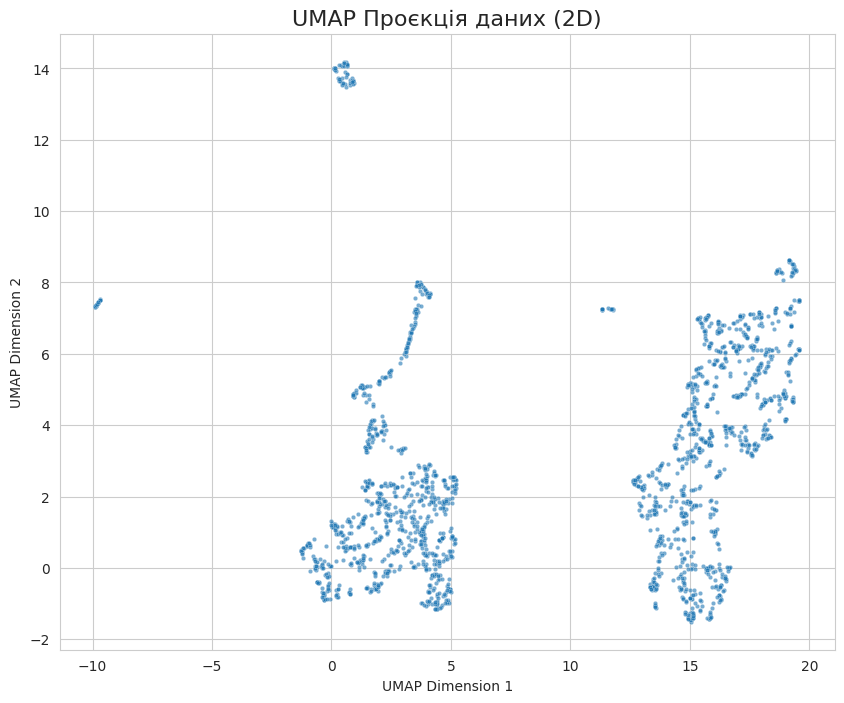

In [0]:
# 8. ВІЗУАЛІЗАЦІЯ UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


print("Візуалізація UMAP...")

# Налаштування стилю
sns.set_style("whitegrid")

# Створення фігури та осей
plt.figure(figsize=(10, 8))

# Побудова точкової діаграми
sns.scatterplot(
    x='umap_1', 
    y='umap_2', 
    data=pca_sample_pd, 
    s=10, # Розмір точок
    alpha=0.6, # Прозорість
    
)

plt.title('UMAP Проєкція даних (2D)', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

In [0]:
# 8. Збереження результату

output_path = "/Volumes/workspace/default/olist_delta_3"

olist_df.write.format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .save(output_path)

print("Результат збережено у:", output_path)


Результат збережено у: /Volumes/workspace/default/olist_delta_3
